<a href="https://colab.research.google.com/github/harsha-bsm/attention-based-aspect-extraction/blob/main/WORKINGFILE_modularising_Atten_based_Aspect_Extraction_POC_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Mounting files on google drive which will ease file accessing 
from google.colab import drive
drive.mount('/content/drive/') 

Mounted at /content/drive/


In [2]:
#%%writefile /content/drive/MyDrive/REVIEWS/preprocess.py
# importing necessary modules
!pip install emot
import emot
import os
import matplotlib.pyplot as plt

# import seaborn as sns
import pandas as pd
from gensim.models import FastText 
import re
import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, Dense,Concatenate,TimeDistributed,Masking,GRU,Input,Dot,Reshape,Softmax
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
# Using NLTK for PoS tagging and Stopwords removal
# Downloading the corresponding packages
import pickle
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
from nltk.corpus import stopwords
import numpy as np
from gensim.models import FastText 
from random import seed
from random import randint
from sklearn.cluster import KMeans

from nltk.corpus import stopwords
DATA_PATH="/content/drive/My Drive/REVIEWS/"
raw_file="reviews.pickle"
preprocessed_file="preprocessed_df.pickle"
trained_embeddings="trained_embeddings"
padded_seqfile="padded_sequences.pickle"
train_again=True
vocabtrain_again=False
stopword=stopwords.words(fileids="english")
buffer_size=1024
batch_size=100
negative_samples=20


#  removing some of the common contractions.
def decontractions(phrase):
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"won\’t", "will not", phrase)
    phrase = re.sub(r"can\’t", "can not", phrase)
    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    phrase = re.sub(r"n\’t", " not", phrase)
    phrase = re.sub(r"\’re", " are", phrase)
    phrase = re.sub(r"\’s", " is", phrase)
    phrase = re.sub(r"\’d", " would", phrase)
    phrase = re.sub(r"\’ll", " will", phrase)
    phrase = re.sub(r"\’ve", " have", phrase)
    phrase = re.sub(r"\’m", " am", phrase)
    return phrase

def convert_emojis(review):
  for x in review:
    if x in emot.emo_unicode.UNICODE_EMOJI.keys():
      review=review.replace(x,"")
  return review

#Converting all the extra spaces into single space. This will help while splitting the data in the future.
def removecharacters(review):
  review= re.sub('[^A-Za-z0-9]+',' ',review)  #anything exept numbers and alphabets, replace them with space
  review=re.sub(r"\n"," ",review)  #new lines into space
  review=re.sub(r"\t"," ",review)  #tabs into space
  review=re.sub(r"\v"," ",review)  #vertical tab into space
  review=re.sub(r"\s"," ",review)   #all extra spaces into single space
  return review.lower()

def removenewords(review,wordcountdict):
  return " ".join([word for word in review.split(" ") if  word in list(wordcountdict.keys())])

def removestopwords(review,stopword):
  return " ".join([word for word in review.split(" ") if not word in stopword])

def word_count(review,wordcountdict,min_word_repeat):
  return  " ".join([word for word in review.split() if wordcountdict[word]>min_word_repeat] )



def text_processing(stopword=stopword,min_word_repeat=10,sent_len_percentile=99.9,dump_aspickle=True,return_df=False):
  #stop_words=set(stopwords.words('english'))
  raw_path=os.path.join(DATA_PATH,raw_file)
  preprocessed_path=os.path.join(DATA_PATH,preprocessed_file)
  if os.path.isfile(preprocessed_path):
    preprocessed_df=pd.read_pickle(preprocessed_path)
  else:
    df = pd.read_pickle(raw_path)
    df["review"]=df["review"].apply(lambda x:x.strip("READ MORE").lower())
    df["review"]=df["review"].apply(convert_emojis)
    df["review"]=df["review"].apply(decontractions)
    df["review"]=df["review"].apply(removecharacters)
    df["review"]=pd.DataFrame(df["review"].apply(lambda x:removestopwords(x,stopword)))
    df["len"]=df.review.str.split().apply(len)
    l=np.percentile(df.len,sent_len_percentile)
    df=df.loc[(df["len"]>0) & (df["len"]<l+1)]
    tkn = Tokenizer(filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n') #tensorflow tokenising
    tkn.fit_on_texts(df['review'].values)
    word_countdict=tkn.word_counts  #word count dictionary
    df["review"]=pd.DataFrame(df["review"].apply(lambda x:word_count(x,word_countdict,min_word_repeat)))
    df["len"]=df.review.str.split(" ").apply(len)
    if  dump_aspickle:
      with open(preprocessed_path,"wb") as file:
        pickle.dump(df.loc[df["len"]>0],file)
    preprocessed_df=df.loc[df["len"]>0]
  if return_df:
    return preprocessed_df


def tokenisation_on_traindata(return_tkn=True):
  if os.path.isfile(os.path.join(DATA_PATH,preprocessed_file)):
    train=pd.read_pickle(os.path.join(DATA_PATH,preprocessed_file))
  else:
    train=text_processing(stopword=stopword,min_word_repeat=10,sent_len_percentile=99.9,dump_aspickle=True,return_df=True)
  tkn = Tokenizer(filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n') #tensorflow tokenising
  tkn.fit_on_texts(train['review'].values)
  with open(os.path.join(DATA_PATH,"token.pickle"),"wb") as file:
    pickle.dump(tkn,file)
  if return_tkn:
    return tkn


def training_vocab(embed_dim=100,negative_sampling=5,min_count=1,window=10,iter=250,sg=1,train_again=vocabtrain_again,return_model=True):
  preprocessed_path=os.path.join(DATA_PATH,preprocessed_file)
  if os.path.isfile(preprocessed_path):
    df=pd.read_pickle(preprocessed_path)
  else:
    df=text_processing(stopword=set(stopwords.words('english')),return_df=True)
  tkn = Tokenizer(filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n')
  tkn.fit_on_texts(df['review'].values)
  word_countdict=tkn.word_counts
  seq_texts=tkn.texts_to_sequences(df['review'].values)  #converting tokenised reviews into sequence of
# integers with each integer corresponding to one word in the corpus
  text=pd.Series(df['review'].values).apply(lambda x: x.split())  #spliting the reviews in a format suitable to  feed 
#into Fasttext for trainig vocab 

  trained_embeddings_path=os.path.join(DATA_PATH,trained_embeddings)
  if os.path.isfile(trained_embeddings_path):
    if train_again:
      model = FastText(size=embed_dim, negative=negative_sampling, min_count=min_count,window=window,iter=iter,sg=sg) 
      model.build_vocab(text) 
      gensim_fasttext = model.train(sentences=text, 
                           sg=sg, ##skipgram
                           epochs=iter, ##no of iterations
                           size=embed_dim, ##dimentions of word embedding
                           seed=1,
                           total_examples=model.corpus_count)
      model.save(trained_embeddings_path)
    else:
      model=FastText.load(trained_embeddings_path)
  else:
    model = FastText(size=embed_dim, negative=negative_sampling, min_count=min_count,window=window,iter=iter,sg=sg) 
    model.build_vocab(text)
    gensim_fasttext = model.train(sentences=text, 
                           sg=sg, ##skipgram
                           epochs=iter, ##no of iterations
                           size=embed_dim, ##dimentions of word embedding
                           seed=1,
                           total_examples=model.corpus_count)
    model.save(trained_embeddings_path)
  
  
  if return_model:
    return model

def textinputsequence_padding(padding="post",padded_seqagain=train_again,return_paddedsequences=True):
  preprocessed_path=os.path.join(DATA_PATH,preprocessed_file)
  padded_seqpath=os.path.join(DATA_PATH,padded_seqfile)
  if os.path.isfile(preprocessed_path):
    df=pd.read_pickle(preprocessed_path)
  else:
    df=text_processing(stopword=set(stopwords.words('english')),return_df=True)
  if os.path.isfile(padded_seqpath):

    if padded_seqagain:
      tkn = Tokenizer(filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n')
      tkn.fit_on_texts(df['review'].values)
      word_countdict=tkn.word_counts
      seq_texts=tkn.texts_to_sequences(df['review'].values)
      seq_texts=tf.keras.preprocessing.sequence.pad_sequences(seq_texts,
                                                         maxlen=max(df.len),
                                                         padding=padding)
      with open(os.path.join(DATA_PATH,"padded_sequences.pickle"),"wb") as file:
        pickle.dump(seq_texts,file)
    else:
      with open(padded_seqpath,"rb") as file:
        seq_texts=pickle.load(file)
  else:
    tkn = Tokenizer(filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n')
    tkn.fit_on_texts(df['review'].values)
    word_countdict=tkn.word_counts
    seq_texts=tkn.texts_to_sequences(df['review'].values)
    seq_texts=tf.keras.preprocessing.sequence.pad_sequences(seq_texts,
                                                         maxlen=max(df.len),
                                                         padding=padding)
    with open(os.path.join(DATA_PATH,"padded_sequences.pickle"),"wb") as file:
      pickle.dump(seq_texts,file)

  if return_paddedsequences:
    return seq_texts


def generate_dataset(buffer_size=buffer_size,batch_size=batch_size,negative_samples=negative_samples):
  if  os.path.isfile(os.path.join(DATA_PATH,padded_seqfile)):
    with open(os.path.join(DATA_PATH,"padded_sequences.pickle"),"rb") as file:
      seq_texts=pickle.load(file)
  else:
    seq_texts=textinputsequence_padding(padding="post",padded_seqagain=train_again,return_paddedsequences=True)

  def gendata():
    seed(42)
    for i in range(0,len(seq_texts)):
      lis=[]
      lent=[]
      while len(lent)<negative_samples:
        value = randint(0, len(seq_texts)-1)
        if value==i:
          continue
        lis.append(seq_texts[value])
        lent.append(value)
      yield seq_texts[i],lis
  dataset=tf.data.Dataset.from_generator(gendata, output_types=(tf.int32,tf.int32))
  dataset=dataset.repeat(1).shuffle(buffer_size=buffer_size).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
  return dataset

     |████████████████████████████████| 61 kB 18 kB/s 
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


#### Building custom attention layer

In [3]:
#%%writefile /content/drive/MyDrive/REVIEWS/model.py



# importing necessary modules

import emot
import os
import matplotlib.pyplot as plt

# import seaborn as sns
import pandas as pd
from gensim.models import FastText 
import re
import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, Dense,Concatenate,TimeDistributed,Masking,GRU,Input,Dot,Reshape,Softmax
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
# Using NLTK for PoS tagging and Stopwords removal
# Downloading the corresponding packages
import pickle
import nltk

from nltk.corpus import stopwords
import numpy as np
from gensim.models import FastText 
from random import seed
from random import randint
from sklearn.cluster import KMeans

embed_outputdim=100
aspects_k=10 #number of aspects

def embedding_layerinit():
  model=training_vocab(embed_dim=embed_outputdim,negative_sampling=5,min_count=1,window=10,iter=250,sg=1,train_again=vocabtrain_again,return_model=True)
  trained_weights=np.vstack((np.zeros((1,100)),model.wv.vectors))
  return trained_weights,model

def inputlength():
  seq=textinputsequence_padding(padding="post",padded_seqagain=train_again,return_paddedsequences=True)
  return seq.shape[1]


def aspectlayer_weightinit():
  trained_weights=embedding_layerinit()[0]
  kmeans = KMeans(n_clusters=aspects_k,random_state=0,max_iter=500,n_jobs=-1).fit(trained_weights) #clustering the trained wordembeddings into 10 clusters
  init=tf.constant_initializer(kmeans.cluster_centers_) #used for initialing the weights of final dense layer
  return init

class Attention(tf.keras.layers.Layer):
    def __init__(self):
      super().__init__()
      #self.embed_outputdim=embed_outputdim
      self.soft = tf.keras.layers.Softmax(axis=-2,name="softmax_att") #softmax layer
      self.dot=tf.keras.layers.Dot(axes=(-1,-1),name="dot_att")       #dot layer
      self.w = tf.Variable(
            initial_value=tf.random_normal_initializer()(shape=(embed_outputdim,embed_outputdim), dtype="float32"),
            trainable=True,
        )              #weights that captures essense between the word embedding and global context vector(or average of all the word embedding of the sentence)
  
    def call(self,embed_output, mask=None):

      ys = tf.reduce_mean(embed_output,axis=-2) #average of all word embeddings of the sentence
      ys=tf.expand_dims(ys,axis=-2)
      eW=tf.matmul(embed_output, self.w)
      eW = eW * tf.expand_dims(tf.cast(mask,tf.float32),-1) #maskpropagation. Preventing masked elements into calculations
      f=self.dot([eW, ys])
      f = f+tf.expand_dims(tf.cast(tf.math.equal(mask, False), f.dtype)*-1e9,-1) #multiplying all the masked elements by -1e9 so that the softmax step do not impact the vectors
      f=self.soft(f)
      zs=tf.math.reduce_sum(f*embed_output,axis=-2) #zs is aspect embedding space after attention mechanisms on words of the sentence
                                                    # f - softmax - gives info about unimportant words in the sentence for extracting aspects 
      
      return zs,f


# custom model

class model_(tf.keras.Model):
  def __init__(self,embed_outputdim,aspects_k):
    super().__init__()
    self.embed_inputdim=len(embedding_layerinit()[1].wv.vocab)
    self.inputlength=inputlength()
    self.embed_outputdim=embed_outputdim
    self.trained_weights=embedding_layerinit()[0]
    self.embedding=Embedding(input_dim=self.embed_inputdim+1,output_dim=self.embed_outputdim,mask_zero=True,
                             input_length=self.inputlength,weights=[self.trained_weights],name="embedding_layer",trainable=True) #embedding layer. Zero masking
    self.attention=Attention()
    self.aspects_k=aspects_k #number of aspects
    self.init=aspectlayer_weightinit()
    self.k = tf.keras.layers.Dense(aspects_k,name="dim_reduction_layer",activation="softmax")
    self.dense= self.trained_weights.shape[1]
    self.final=tf.keras.layers.Dense(self.dense,name="final_dense",kernel_initializer=self.init) #weights are initialised with embedding clusters
  def call(self,input):
    e=self.embedding(input[0])
    mask = self.embedding.compute_mask(input[0]) #computing mask so that this this can be used while propagating mask for subsequent layers
    zs=self.attention(e, mask = mask)[0] #aspect vector
    pt=self.k(zs)  #dimensionality vector
    rs=self.final(pt) #reconstructed vector

    # building regulariser to be used in the loss. [(T*transpose(T))-I]
    reg=tf.tensordot(tf.linalg.normalize(self.final.weights[0],axis=1)[1],tf.linalg.normalize(self.final.weights[0],axis=1)[1],axes=[[1],[1]])
    reg=reg-tf.ones([self.aspects_k,self.aspects_k])
    reg=tf.norm(reg, ord='euclidean', axis=None, keepdims=None, name=None)
    # calculating loss
    r=tf.expand_dims(rs,-2)
    f=tf.tensordot(rs,zs,[[0,1],[0,1]])
    a=self.embedding(input[1])
    a=tf.reduce_mean(a,axis=-2)
    loss=tf.reduce_sum(tf.nn.relu(1-tf.reduce_sum(tf.tensordot(a,r,[[0,2],[0,2]]))+f))+1*reg #this is the loss which is to be minimised
    return loss,pt,rs 
    
    
  def get_config(self):
    config = {
                  'embed_outputdim': self.embed_outputdim,
                  'aspects_k' : self.aspects_k}
    return config
  @classmethod
  def from_config(cls, config):
    return cls(**config)


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
#%%writefile /content/drive/MyDrive/REVIEWS/config.py
from nltk.corpus import stopwords
DATA_PATH="/content/drive/My Drive/REVIEWS/"
raw_file="reviews.pickle"
preprocessed_file="preprocessed_df.pickle"
trained_embeddings="trained_embeddings"
padded_seqfile="padded_sequences.pickle"
train_again=True
vocabtrain_again=False
stopword=stopwords.words(fileids="english")
embed_outputdim=100
aspects_k=10 #number of aspects
buffer_size=1024
batch_size=100
negative_samples=20
WEIGHTS_PATH="/content/drive/My Drive/REVIEWS/Weights"
CHECKPOINTS_PATH="/content/drive/My Drive/REVIEWS/checkpoints"
lr=0.001
iterations=15
return_bestweightspath=True

MODEL_CONFIG = {'embed_outputdim': embed_outputdim,
                  'aspects_k' : aspects_k}


#### Building tensorflow dataset from generators

In [ ]:
def gendata():
    seed(42)
    for i in range(0,len(seq_texts)):
      lis=[]
      lent=[]
      while len(lent)<negative_samples:
        value = randint(0, len(seq_texts)-1)
        if value==i:
          continue
        lis.append(seq_texts[value])
        lent.append(value)
      yield seq_texts[i],lis
dataset=tf.data.Dataset.from_generator(gendata, output_types=(tf.int32,tf.int32))
dataset=dataset.repeat(1).shuffle(buffer_size=1024).batch(100).prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
dataset=generate_dataset(buffer_size=1024,batch_size=100,negative_samples=20)

#### Model training

In [6]:

#%%writefile /content/drive/MyDrive/REVIEWS/training.py
import emot
import os
import matplotlib.pyplot as plt
import pandas as pd
from gensim.models import FastText 
import re
import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, Dense,Concatenate,TimeDistributed,Masking,GRU,Input,Dot,Reshape,Softmax
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
# Using NLTK for PoS tagging and Stopwords removal
# Downloading the corresponding packages
import pickle
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
from nltk.corpus import stopwords
import numpy as np
from gensim.models import FastText 
from random import seed
from random import randint
from sklearn.cluster import KMeans
#from config import *
#from model import model_

WEIGHTS_PATH="/content/drive/My Drive/REVIEWS/Weights/"
CHECKPOINTS_PATH="/content/drive/My Drive/REVIEWS/checkpoints"

lr=0.001
iterations=1
return_bestweightspath=True 

def training(WEIGHTS_PATH,CHECKPOINTS_PATH,model_,lr=lr,iterations=iterations,return_bestweightspath=return_bestweightspath):
  abae=model_(embed_outputdim,aspects_k)
  optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
  @tf.function
  def train_step(input):
      with tf.GradientTape() as tape:
        loss = abae(input)[0]
      gradients = tape.gradient(loss, abae.trainable_variables)
      optimizer.apply_gradients(zip(gradients, abae.trainable_variables))
      return loss, gradients
  train_loss = tf.keras.metrics.Mean(name='train_loss')
##check point to save
  ckpt = tf.train.Checkpoint(optimizer=optimizer, model=abae)
  ckpt_manager = tf.train.CheckpointManager(ckpt, CHECKPOINTS_PATH, max_to_keep=3)
  
  loss_list=[]
  weights_pathlist=[]
  for k in range(0,iterations): # k - number of iterations
    counter = 0

  # navigating through each batch
    for input in dataset:
      loss_, gradients = train_step(input)
      #adding loss to train loss
      train_loss(loss_)
      counter = counter + 1
      template = '''Done {} step, Loss: {:0.6f}'''
      if counter%500==0:
        print(template.format(counter, train_loss.result()))

    loss_list.append(train_loss.result()) #appending loss after every epoch
    ckpt_save_path  = ckpt_manager.save() #checkpointing after every epoch
    X=os.path.join(WEIGHTS_PATH,"weights_epoch_"+str(k+1))
    abae.save_weights(X,save_format="h5")

    weights_pathlist.append(X)
    
    print("weights saved after epoch {}".format(k+1))
    print ('Saving checkpoint for iteration {} at {}'.format(k+1, ckpt_save_path))
    print(counter, train_loss.result())
    train_loss.reset_states()             #resetting loss after every epoch
  if return_bestweightspath:
    argminimum=np.argmin(loss_list)
    return weights_pathlist[argminimum]  
  


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


ModuleNotFoundError: ignored

In [ ]:
checkpoint_path="/content/drive/My Drive/REVIEWS/checkpoints"
abae=model_(embed_outputdim,aspects_k)
latest = tf.train.latest_checkpoint(checkpoint_path)
ckpt = tf.train.Checkpoint(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), model=abae)
ckpt.restore(latest)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=3)

In [ ]:
model_.from_config(MODEL_CONFIG)

In [29]:
inf=model_.from_config(MODEL_CONFIG)

In [30]:
for i in generate_dataset().take(2):
  k=i

In [31]:
inf(k)
inf.load_weights("/content/drive/My Drive/REVIEWS/trainedWEIGHTS")

In [ ]:
predict(k[0][1],"/content/drive/My Drive/REVIEWS/trainedWEIGHTS",model_,MODEL_CONFIG)

'belongs to topic_4'

In [ ]:
testsample="price is very reasonable"

In [ ]:
  tkn=tokenisation_on_traindata(return_tkn=True)
  word_countdict=tkn.word_counts 
  word_countdict.keys


<function OrderedDict.keys>

In [8]:
%%writefile /content/drive/MyDrive/REVIEWS/predict.py
import emot
import os
import matplotlib.pyplot as plt
import pandas as pd
from gensim.models import FastText 
import re
import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, Dense,Concatenate,TimeDistributed,Masking,GRU,Input,Dot,Reshape,Softmax
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
# Using NLTK for PoS tagging and Stopwords removal
# Downloading the corresponding packages
import pickle
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
from nltk.corpus import stopwords
import numpy as np
from gensim.models import FastText 
from random import seed
from random import randint
from sklearn.cluster import KMeans
from config import *
from model import model_
from preprocess import *
from training import *



def seq_gen(testsample,maxlen=223)  :
  df=pd.DataFrame([testsample],columns=["review"])
  df["review"]=df["review"].apply(lambda x:x.strip("READ MORE").lower())
  df["review"]=df["review"].apply(convert_emojis)
  df["review"]=df["review"].apply(decontractions)
  df["review"]=df["review"].apply(removecharacters)
  df["review"]=pd.DataFrame(df["review"].apply(lambda x:removestopwords(x,stopword)))
  df["len"]=df.review.str.split().apply(len)
  df=df.loc[(df["len"]>0) & (df["len"]<maxlen+1)]
  tkn=tokenisation_on_traindata(return_tkn=True)
  word_countdict=tkn.word_counts  #word count dictionary
  df["review"]=pd.DataFrame(df["review"].apply(lambda x:removenewords(x,word_countdict)))
  df["review"]=pd.DataFrame(df["review"].apply(lambda x:word_count(x,word_countdict,10)))
  
  seq_texts=tkn.texts_to_sequences(df['review'].values)
  print(seq_texts)
  seq_texts=tf.keras.preprocessing.sequence.pad_sequences(seq_texts,
                                                         maxlen=maxlen,
                                                         padding='post')
  return seq_texts

def topicpredict(testsample,weight_path,model_,MODEL_CONFIG,maxlen=223):
  k=tf.random.uniform(shape=[100,223],minval=1,maxval=38,dtype=tf.int32),tf.random.uniform(shape=[100,20,223],minval=1,maxval=38,dtype=tf.int32)
  inf=model_.from_config(MODEL_CONFIG)
  inf(k)
  inf.load_weights(weight_path)
  l=inf.layers
  seq_text=seq_gen(testsample,maxlen=maxlen)
  sample=seq_text.reshape(1,maxlen)
  endsample=l[0](sample)
  mask=l[0].compute_mask(sample)
  att=l[1](endsample,mask)[0]  
  topic_num=np.argmax(l[2](att))+1
  return "belongs to topic_"+str(topic_num),l[2](att)



Overwriting /content/drive/MyDrive/REVIEWS/predict.py


In [ ]:
sample=k[0][1].numpy().reshape(1,223)
emb=l[0](sample)
mask=l[0].compute_mask(sample)
att=l[1](emb,mask)[0]
pt=l[2](att)
pt

In [17]:
topicpredict("gaming tho acha hai","/content/drive/My Drive/REVIEWS/trainedWEIGHTS",model_,MODEL_CONFIG,maxlen=223)

NameError: ignored

In [130]:
l=inf.layers
l

In [146]:
sample=k[0][1].numpy().reshape(1,223)
emb=l[0](sample)
mask=l[0].compute_mask(sample)
att=l[1](emb,mask)[0]
pt=l[2](att)
pt

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[0.07538455, 0.11304139, 0.10993138, 0.104953  , 0.09605172,
        0.1072276 , 0.0917433 , 0.08850341, 0.12209129, 0.09107236]],
      dtype=float32)>

In [ ]:
emdsample=inf.layers[0](sample)


<tf.Tensor: shape=(1, 223, 100), dtype=float32, numpy=
array([[[ 0.28434345,  0.3539412 , -0.03884524, ...,  0.08158847,
          0.06795241, -0.03691028],
        [ 0.09312745,  0.0665113 , -0.01089542, ...,  0.01330447,
         -0.25797328,  0.03294387],
        [-0.2916876 , -0.02874304,  0.01857883, ...,  0.14095038,
         -0.0856531 , -0.15893033],
        ...,
        [ 0.01035531,  0.01036448,  0.01037198, ...,  0.01034254,
         -0.01036166,  0.01037487],
        [ 0.01035531,  0.01036448,  0.01037198, ...,  0.01034254,
         -0.01036166,  0.01037487],
        [ 0.01035531,  0.01036448,  0.01037198, ...,  0.01034254,
         -0.01036166,  0.01037487]]], dtype=float32)>

In [ ]:
att=inf.layers[1](emdsample)[0]
att

<tf.Tensor: shape=(1, 100), dtype=float32, numpy=
array([[-0.03784817,  0.04932524,  0.00909207, -0.03855411,  0.03189919,
        -0.05768111,  0.28769803, -0.0539141 , -0.2119304 ,  0.13761231,
        -0.19599375,  0.15078266,  0.12766425, -0.15458861,  0.05844464,
         0.00605304,  0.08107603, -0.13156097, -0.0095018 ,  0.07236446,
         0.0761936 ,  0.00411951, -0.18544461, -0.04545902, -0.0270914 ,
         0.13593271, -0.22507998,  0.06798376, -0.13280551,  0.01041025,
         0.05213068,  0.17390668,  0.202806  ,  0.14431584,  0.14312342,
         0.1353922 ,  0.02476707,  0.06251456,  0.12323368, -0.00152758,
         0.03922736, -0.18883106,  0.13550267,  0.12107454, -0.04419479,
         0.2056097 ,  0.01607932, -0.14294998, -0.0288608 ,  0.11756141,
         0.01950871, -0.14338823,  0.07907163, -0.14048326, -0.01465124,
         0.0114028 , -0.1232634 , -0.13779134, -0.05030006,  0.05148183,
         0.00965279, -0.04693422,  0.05502408, -0.14524607,  0.02292041,
 

In [ ]:
inf.layers[2](att)

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[0.0852352 , 0.13147014, 0.0958802 , 0.11055278, 0.08819757,
        0.09580411, 0.08448124, 0.09142829, 0.11823527, 0.09871526]],
      dtype=float32)>

In [ ]:
test.load_weights(os.path.join(DATA_PATH,"_newWeights",str(1)))

In [ ]:
test(k)[0]

<tf.Tensor: shape=(), dtype=float32, numpy=0.010878837>

In [ ]:
abae.save_weights(os.path.join(DATA_PATH,"_newWeights"),save_format="h5")

#### Loss - plot

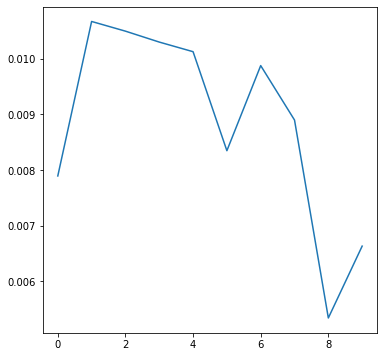

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6,6))
plt.plot(loss_list[1:])
plt.show()

In [ ]:
abae.summary()

Model: "model__1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_layer (Embedding)  multiple                  699800    
_________________________________________________________________
attention_1 (Attention)      multiple                  10000     
_________________________________________________________________
dim_reduction_layer (Dense)  multiple                  1010      
_________________________________________________________________
final_dense (Dense)          multiple                  1100      
Total params: 711,910
Trainable params: 711,910
Non-trainable params: 0
_________________________________________________________________


In [ ]:
for i in abae.weights:
  print(i.name, i.shape)

model__1/embedding_layer/embeddings:0 (6998, 100)
Variable:0 (100, 100)
model__1/dim_reduction_layer/kernel:0 (100, 10)
model__1/dim_reduction_layer/bias:0 (10,)
model__1/final_dense/kernel:0 (10, 100)
model__1/final_dense/bias:0 (100,)


In [9]:
from gensim.models import FastText
model=FastText.load("/content/drive/My Drive/REVIEWS/trained_embeddings") #reusing already trained model

In [25]:
!python "/content/drive/MyDrive/REVIEWS/training.py"

2021-08-16 05:21:36.256373: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [34]:
!python "/content/drive/MyDrive/REVIEWS/predict.py"

2021-08-16 05:33:52.046366: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Camera is awesome
2021-08-16 05:34:06.770771: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-08-16 05:34:06.783645: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-08-16 05:34:06.783697: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (74ab1ff4eadb): /proc/driver/nvidia/version does not exist
2021-08-16 05:35:00.570

In [36]:
topics=inf.weights[4].numpy()  
topic_words={}
k=1
for i in range(len(topics)):
  topic_words["topic_"+str(k)]=np.argsort(model.wv.cosine_similarities(topics[i],model.wv.vectors))[::-1][0:20]
  k=k+1
pd.DataFrame(topic_words).applymap(lambda x:model.wv.index2word[x])

,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10
0,rs,played,cameras,notifications,nice,far,body,ke,cancel,s9
1,offer,games,depth,app,xilent,think,case,hai,deliver,obviously
2,discount,graphics,images,exit,osm,comparison,thin,liye,delivered,terms
3,discounts,runs,portrait,messages,vry,really,design,bhi,order,absolutely
4,price,almost,capture,operations,nyc,aspects,fits,h,informed,s8
5,deal,90,captures,apps,sm,actually,grip,hota,address,beast
6,discounted,heavy,daylight,application,lovly,trust,slippery,acha,promised,flagships
7,12000,playing,lens,restart,good,one,feels,ki,assured,flagship
8,999,gaming,rear,applications,nais,better,silicon,nhi,asked,barring
9,13000,pubg,wide,whatsapp,super,believe,looks,accha,customer,amazing


In [45]:
import json
topics_inf={}
topics_inf[1]="price and sale"
topics_inf[2]="gaming experience"
topics_inf[3]="camera and pictures"
topics_inf[4]="apps and notifications"
topics_inf[5]="misspelt and positive words"
topics_inf[6]="coparision"
topics_inf[7]="physical design and experience"
topics_inf[8]="hindi word"
topics_inf[9]="delivery"
topics_inf[10]="premium phones"
with open("/content/drive/My Drive/REVIEWS/topics_inf.json","w+") as file:
  json.dump(topics_inf,file)

In [ ]:
topics=inf.weights[4].numpy()  
topic_words={}
k=1
for i in range(len(topics)):
  topic_words["topic_"+str(k)]=np.argsort(model.wv.cosine_similarities(topics[i],model.wv.vectors))[::-1][0:20]
  k=k+1
pd.DataFrame(topic_words).applymap(lambda x:model.wv.index2word[x])  

,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10
0,rs,played,cameras,notifications,nice,far,body,ke,cancel,s9
1,offer,games,depth,app,xilent,think,case,hai,deliver,obviously
2,discount,graphics,images,exit,osm,comparison,thin,liye,delivered,terms
3,discounts,runs,portrait,messages,vry,really,design,bhi,order,absolutely
4,price,almost,capture,operations,nyc,aspects,fits,h,informed,s8
5,deal,90,captures,apps,sm,actually,grip,hota,address,beast
6,discounted,heavy,daylight,application,lovly,trust,slippery,acha,promised,flagships
7,12000,playing,lens,restart,good,one,feels,ki,assured,flagship
8,999,gaming,rear,applications,nais,better,silicon,nhi,asked,barring
9,13000,pubg,wide,whatsapp,super,believe,looks,accha,customer,amazing


#### Aspects

In [ ]:
pd.DataFrame(topic_words).applymap(lambda x:model.wv.index2word[x])

,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10
0,rs,amoled,deliver,awesome,feels,achha,turn,stunning,nice,fraud
1,billion,stunning,shipping,really,classy,koi,notifications,disappoint,good,seller
2,discount,amazing,ekart,phone,grip,mast,app,great,nicr,refused
3,offer,cameras,30th,good,sleek,hai,disable,awesome,awesome,fault
4,3500,awesome,ordered,superb,premium,ko,access,really,wesome,sent
5,discounts,brilliant,delivered,also,design,acha,application,amazing,greate,executives
6,13500,outstanding,delivery,one,looks,nhi,vibrate,indeed,thanku,accepting
7,3k,ai,flipkart,great,handy,kharab,irritates,beast,avarge,accept
8,13000,decent,saturday,excellent,hold,ek,bluetooth,loving,mast,replacement
9,8999,really,oct,battery,slippery,ki,button,outstanding,fantastic,flipkart


In [ ]:
df.shape

(362996, 4)

In [ ]:
actual=pd.read_pickle("/content/drive/My Drive/REVIEWS/reviews.pickle")
actual.shape

(363572, 3)

### Restoring the training of a model from the latest checkpoint

In [38]:
#data generating
from random import seed
from random import randint

def gendata():
  seed(42)
  for i in range(0,len(seq_texts)):
    lis=[]
    lent=[]
    while len(lent)<20:
      value = randint(0, len(seq_texts)-1)
      if value==i:
        continue
      lis.append(seq_texts[value])
      lent.append(value)

    yield seq_texts[i],lis
datagen=tf.data.Dataset.from_generator(gendata, output_types=(tf.int32,tf.int32))
datagen=datagen.repeat(1).shuffle(buffer_size=1024).batch(100).prefetch(tf.data.experimental.AUTOTUNE)

In [39]:
for i in datagen.take(1):
  k=i
test=model_(embed_outputdim,aspects_k)
_=test(i)
test.load_weights(os.path.join(DATA_PATH,"_newWeights"))   

UnknownError: ignored

In [ ]:
test

In [ ]:
#model initialisation
#abae=model_(embed_inputdim,embed_outputdim,trained_weights,aspects_k,dense,inputlength)
# optimiser
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
@tf.function
def train_step(input):
    with tf.GradientTape() as tape:
        #forward propagation
        loss = test(input)[0]
        #print(loss)

    #getting gradients
    gradients = tape.gradient(loss, test.trainable_variables)
    #applying gradients
    optimizer.apply_gradients(zip(gradients, test.trainable_variables))

    return loss, gradients
#no_iterations=1147*5          #epochs
train_loss = tf.keras.metrics.Mean(name='train_loss')


checkpoint_path = "/content/drive/My Drive/abae_logs/checkpoints/abae/train"
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
ckpt = tf.train.Checkpoint(optimizer=optimizer, model=test)

latest = tf.train.latest_checkpoint(checkpoint_path)
ckpt.restore(latest)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=3)


##check point to save
#checkpoint_path = "/content/drive/My Drive/abae_logs/checkpoints/abae/train_v2"
#ckpt = tf.train.Checkpoint(optimizer=optimizer, model=test)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=3)


it=0
loss_list=[]
for k in range(0,1):
  counter = 0
  for input in datagen:

      loss_, gradients = train_step(input)
      #adding loss to train loss
      train_loss(loss_)
      counter = counter + 1
      template = '''Done {} step, Loss: {:0.6f}'''

    
      if counter%100==0:
        print(template.format(counter, train_loss.result()))
        
  loss_list.append(train_loss.result())
  ckpt_save_path  = ckpt_manager.save()
  print ('Saving checkpoint for iteration {} at {}'.format(k+1, ckpt_save_path))
  print(counter, train_loss.result())
  train_loss.reset_states()
  
  


Done 100 step, Loss: 0.008561
Done 200 step, Loss: 0.008550
Done 300 step, Loss: 0.008563
Done 400 step, Loss: 0.008538
Done 500 step, Loss: 0.008546
Done 600 step, Loss: 0.008532
Done 700 step, Loss: 0.008539
Done 800 step, Loss: 0.008539
Done 900 step, Loss: 0.008542
Done 1000 step, Loss: 0.008534
Done 1100 step, Loss: 0.008536
Done 1200 step, Loss: 0.008532
Done 1300 step, Loss: 0.008531
Done 1400 step, Loss: 0.008532
Done 1500 step, Loss: 0.008530
Done 1600 step, Loss: 0.008528
Done 1700 step, Loss: 0.008530
Done 1800 step, Loss: 0.008530
Done 1900 step, Loss: 0.008526
Done 2000 step, Loss: 0.008526
Done 2100 step, Loss: 0.008525
Done 2200 step, Loss: 0.008523
Done 2300 step, Loss: 0.008524
Done 2400 step, Loss: 0.008524
Done 2500 step, Loss: 0.008521
Done 2600 step, Loss: 0.008521
Done 2700 step, Loss: 0.008522
Done 2800 step, Loss: 0.008518
Done 2900 step, Loss: 0.008518
Done 3000 step, Loss: 0.008517
Done 3100 step, Loss: 0.008516
Done 3200 step, Loss: 0.008515
Done 3300 step, L

In [ ]:
topics=test.weights[4].numpy()
topic_words={}
k=1
for i in range(len(topics)):
  topic_words["Aspect_"+str(k)]=np.argsort(model.wv.cosine_similarities(topics[i],model.wv.vectors))[::-1][0:20]
  k=k+1
pd.DataFrame(topic_words).applymap(lambda x:model.wv.index2word[x])

,Aspect_1,Aspect_2,Aspect_3,Aspect_4,Aspect_5,Aspect_6,Aspect_7,Aspect_8,Aspect_9,Aspect_10
0,rs,amoled,shipping,awesome,feels,achha,turn,disappoint,nice,fraud
1,billion,stunning,deliver,really,classy,koi,notifications,stunning,good,seller
2,discount,amazing,30th,good,grip,mast,access,great,nicr,refused
3,offer,cameras,ekart,phone,sleek,acha,app,awesome,awesome,fault
4,3500,awesome,ordered,superb,premium,kharab,disable,really,greate,executives
5,13000,brilliant,delivered,great,design,hai,vibrate,indeed,wesome,accepting
6,8999,outstanding,delivery,also,looks,ko,irritates,amazing,mast,sent
7,3k,decent,flipkart,excellent,handy,nhi,button,beast,avarge,accept
8,discounts,ai,saturday,one,hold,ek,application,loving,thanku,flipkart
9,13500,especially,august,amazing,hands,ki,icon,outstanding,fantastic,replacement


### Aspects Inference
#### From above collection of words, we can conclude some of the aspects as below ---
Aspect1 - Price

Aspect2 - Camera and the picture display

Aspect3 - Delivery

Aspect4 - Positive intent words

Aspect5 - Physical experience (or features) of mobile

Aspect6 - Collection of Hindi Language words 

Aspect7 - Accessing different applications

Aspect8 - Extreme positive intent about product

Aspect9 - Incorrectly spelled positive intent about product

Aspect10- Bad CustomerService experience